# Problem

The problem at hand is to calculate the covarince resp. the correlation matrix of a signal sample, which has been mixed with a background sample and the true knowledge of which events belong to signal and which belong to background is not present. If it is possible to determine the fraction of signal in the mixed sample as well as the means and the covariance of the background sample the presented way allows to estimate the covariance (and thus the correlation) of the signal sample from the mixed sample.

A problem where all these statements apply is one where a discriminating variable can be used to split the mixed sample into one or more regions with pure background and into a region where signal and background are mixed. One sort of problems that go into this direction are in physics, where often the mass is used as discriminating variable, which allows to define signal regions and mass sidebands. It is often possible to describe the shape of the background as a function of the mass in this kind of problems, which allows to do in many cases some sort of background subtraction. Two possible ways of doing such a background subtraction are:

1. To get the signal distribution of a given variable the distribution of the variable in the signal sample is determined and from this distribution the distribution of the background (determined in the mass sidebands) is subtracted with the appropriate weight, which is in this case the fraction of background in the signal region.
2. To get the signal distribution of a given variable all events are used, but the events in the mass sidebands are weighted negatively, where the weight again has to be chosen appropriately, taking into account how many background events are expected in the signal region.

Both procedures are in principle equivalent and can be used to determine any (joint) distribution of any variable(s) of the signal. However, there are some caveates when it comes to determine correlations between the variables. The main one is that both require a binning of the variables that should be considered, which can lead to only sparsely populated bins if the number of available events is low. Furthermore it is possible that some bins have negative entries, thus the distribution is no longer real, but this can be mitigated by manually setting these bins to 0, as their number should be low (given that the weights have been correctly computed).

The method presented in the following allows to calculate the correlation of the variables in the signal using only the knowledge of the fraction of signal in the mixed sample and the covariance and means of the background sample. It circumvents the problem of having to use negative weights in the calculation of a weighted covariance, which is probably not well defined.

# Symbolic calculations

## Definition of symbols
Define some symbols, denote the $\mu$ vectors as non-commutative for the correct behaviour. $C_S$ and $C_B$ are symmetric matrices, thus they need not be declared as non-commutative ($A = A^T$ for symmetric matrices).

In principle sympy should also support some symbolic computations using matrices, but as far as I understood the documentation that only works with fixed dimensions (not really a problem here) and the support for simplification, etc. is not as far as is for "normal" symbols.

The defined symbols are:
- $p = \frac{n_S}{n}$, the fraction of signal events, with $(1-p) = \frac{n_B}{n}$ the fraction of background events in the mixed sample
- $\mu_{S},\mu_B,\mu$, the vector of the means of the signal, the background, resp. the mixed sample
- $C_{S}, C_B$, the covariance matrices of the signal, resp. background sample

The $\mu$ vectors have to be defined twice, to have a transposed version as well.

In [1]:
import sympy as sp
sp.init_printing()

In [2]:
C_S = sp.Symbol('C_S')
C_B = sp.Symbol('C_B')
C = sp.Symbol('C')
p = sp.Symbol('p', real=True)
mu = sp.Symbol('mu', commutative=False)
muT = sp.Symbol('mu^T', commutative=False)
mu_B = sp.Symbol('mu_B', commutative=False)
mu_BT = sp.Symbol('mu_B^T', commutative=False)

$\mu_S$ can be calculated from $\mu$ and $\mu_B$ since $\mu:=E[x]=p\cdot\mu_S + (1-p)\cdot\mu_B \rightarrow \mu_S = \frac{1}{p}(\mu - (1-p)\mu_B)$

In [3]:
mu_S = 1/p * mu - (1-p)/p * mu_B
mu_ST = 1/p * muT - (1-p)/p * mu_BT

### Covariance matrix of the mixed sample


$$C = p\cdot(C_S + \mu_S\mu_S^T) + (1-p)\cdot(C_B + \mu_B\,u_B^T) - (p\mu_S + (1-p)\mu_B)(p\mu_S^T + (1-p)\mu_B^T)$$

In [4]:
cov = p * (C_S + mu_S*mu_ST) + (1-p)*(C_B + mu_B*mu_BT) - (p * mu_S + (1 - p) * mu_B) * (p * mu_ST + (1 - p) * mu_BT)

In [5]:
cov

In [6]:
arguments = (C_S, C_B, mu*muT, mu_B*mu_BT, mu * mu_BT, mu_B * muT) # define list of arguments to collect

After doing some expanding and collecting of terms, the result looks like this:

In [7]:
C_coll = sp.collect(sp.expand(cov), arguments)
C_coll

### Cross check calculation

To check if sympy does the calculation correctly, it is repeated here in a step by step fashion, that is easier to follow along manually. First all terms containing $\mu_S$ are expanded and then simplified as far as possible. After that a manually expanded $C$ is used into which these terms are inserted.

In [8]:
T1 = sp.collect(sp.expand(p**2 * mu_S * mu_ST), arguments)

T2 = sp.collect(sp.expand(p * mu_S * mu_ST), arguments)

T3 = sp.collect(sp.expand(p * mu_S * (1 - p) * mu_BT), arguments)

T4 = sp.collect(sp.expand((1 - p)*p * mu_B * mu_ST), arguments)

In [9]:
T1

In [10]:
T2

In [11]:
T3

In [12]:
T4

In [13]:
FT = p*C_S + T2 + (1-p) * C_B + (1-p) * mu_B*mu_BT - T1 - T3 - T4 - (1-p)**2 * mu_B * mu_BT
sp.collect(sp.expand(FT), arguments)

This is the same result as above, with the only difference that the intermediate terms have been manually checked.

## Covariance of the signal
Unfortunately sympy (or more probably me in combination with sympy) can't solve for $C_S$, so that exercise has to be done manually, which is not all that hard luckily:

$$C_S = \frac{1}{p}[C - (1-p)C_B - \frac{1-p}{p}\mu\mu^T - \frac{1-p}{p}\mu_B\mu_B^T - \frac{p-1}{p}\mu\mu_B^T - \frac{p-1}{p}\mu_B\mu^T] $$

# Toy Test

To check if the calculations from above make any sense a quick toy test is performed. Two samples are randomly drawn from a multivariate normal distribution, with different means, and covariance matrices.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Parameters of the two samples

In [15]:
mu_sig = [0, 2]
c_sig = [[3,-0.5],[-0.5, 2]]
n_sig = 12000
mu_bkg = [2, 3]
c_bkg = [[2, 0.5], [0.5, 1]]
n_bkg = 25000

p = float(n_sig) / (n_sig + n_bkg)

In [16]:
ssig = np.random.multivariate_normal(mu_sig, c_sig, (n_sig))
sbkg = np.random.multivariate_normal(mu_bkg, c_bkg, (n_bkg))

Create mixed sample by appending the two samples from above to each other

In [17]:
sample = np.append(ssig, sbkg, axis=0)

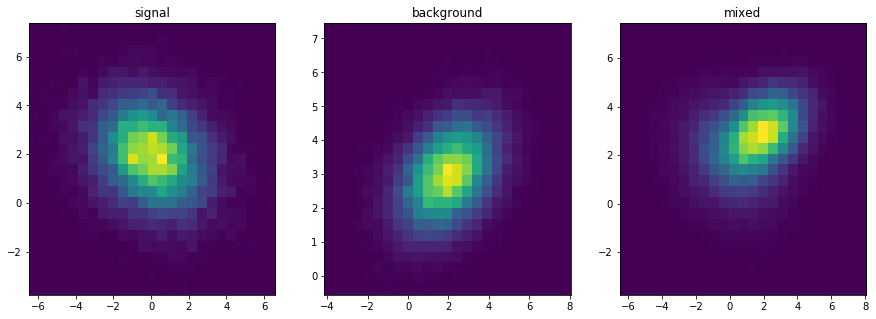

In [18]:
fig = plt.figure(1, figsize=(15,5))
plt.subplot(131)
_,_,_,h2d_bkg = plt.hist2d(ssig[:,0], ssig[:,1], bins=25)
plt.title('signal')
plt.subplot(132)
_,_,_,h2d_sig = plt.hist2d(sbkg[:,0], sbkg[:,1], bins=25)
plt.title('background')
plt.subplot(133)
plt.title('mixed')
_,_,_,h2d_smp = plt.hist2d(sample[:,0], sample[:,1], bins=25)

Define function that calculates the signal covariance matrix from the mixed sample using only information that can be inferred from the mixed sample and the knowledge of the means and the covariance matrix of the background sample and $p$.

In [19]:
from utils.statistics import sig_cov, sig_corr

Calculate covariance matrix of signal sample from mixed sample and the necessary information of the background sample

In [20]:
cov_sig_sample = sig_cov(sample.T, np.average(sbkg.T, axis=1), np.cov(sbkg.T), p)

Check the deviation from the covariance matrix of the signal sample

In [21]:
cov_sig_sample - np.cov(ssig.T)

array([[ -1.51023995e-04,   5.18475520e-05],
       [  5.18475520e-05,  -1.21063985e-04]])

In [22]:
np.cov(ssig.T)

array([[ 2.99660471, -0.51154816],
       [-0.51154816,  1.99675765]])

In [23]:
cov_sig_sample

array([[ 2.99645368, -0.51149631],
       [-0.51149631,  1.99663658]])

# Correlation coefficients

The correlation coefficients are calculated from the covariance matrix via

$$ \text{corr}(X) = \text{diag}(C)^{-1/2}C\text{diag}(C)^{-1/2} $$

where $\text{diag}(C)$ is the matrix of the diagonal elements of $C$ and $C$ is the covariance matrix

In [24]:
np.corrcoef(ssig.T)

array([[ 1.        , -0.20912652],
       [-0.20912652,  1.        ]])

In [25]:
sig_corr(sample.T, np.average(sbkg.T, axis=1), np.cov(sbkg.T), p)

array([[ 1.        , -0.20911694],
       [-0.20911694,  1.        ]])

# Conclusion
The last few tests show that it is indeed possible to determine the covariance (and the correlation) matrix from a mixed sample, if some knowledge about the composition of the mixed sample and the background sample are present. It might be possible that the $C_S$ matrix calculated here is equivalent to the weighted covariance, which would then serve as a "proof" that it is possible to use it even with negative weights, as long as the weights fulfill some conditions. However, I did not check that further as all I needed is already here.